 Medical Appointment No Shows - https://www.kaggle.com/joniarroba/noshowappointments
1. IntroductionFirst impressions
2. Basic Data Wranngling
3. Basic feature engineering
4. Oversampling on predicting Show-Up/No-Show.



## 1. Introduction and First impression

This analysis consist in explore a dataset containing aproximately 100k medial appointments from the Brazilian public health system known as [SUS (Single Health System)](https://en.wikipedia.org/wiki/Sistema_%C3%9Anico_de_Sa%C3%BAde). We're gonna explore the [*no-show appointments dataset*](https://www.kaggle.com/joniarroba/noshowappointments) dataset using this variables:

- **PatientId:** Identification of a patient 
- **AppointmentID:** Identification of each appointment 
- **Gender:** Male or Female 
- **ScheduledDay:** The day of the actuall appointment, when they have to visit the doctor 
- **AppointmentDay:** The day someone called or registered the appointment
- **Age:** How old is the patient 
- **Neighbourhood:** Where the appointment takes place
- [**Scholarship:**](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) True or False, indicates if the patient is in the *Bolsa Familia* program - +500?
- **Hipertension:** True or False
- **Diabetes:** True or False 
- **Alcoholism:** True or False 
- **Handcap:** True or False 
- **SMS_received:** 1 or more messages sent to the patient 
- **No-show** "No" indicates if the patient showed up to their appointment and "Yes" if they didn't show up

We're aiming to find possible reasons for patient no-showing at the scheduled appointments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("../input/KaggleV2-May-2016.csv")
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [2]:
# let's see from which period theese appointments are
df.AppointmentDay.min(), df.AppointmentDay.max()

('2016-04-29T00:00:00Z', '2016-06-08T00:00:00Z')

In [3]:
df.shape

(110527, 14)

In [4]:
#  general numeric attributes
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64


First of all, we can notice that:
- We have 110k+ rows and 14 columns in this dataset 
- I want to check if the patientId is duplicated since I don't know if they can have more than one appointment
- Depending on the analysis, maybe the **PatientId**, **AppointmentID** could be useless for the analysis
- It's important to highlight that the **No-show** column value **Yes** means that the pacient didn't show at the appointment

Also we can already draw some assumptions:
- there are more than 100k appointments scheduled in a period of **~2 months** and that's really impressive
- most of the patients have about 37 yeas old with almost no scholarship (9%)
- in mean 
  - 19% of the patients have hipertension
  - 7% of the patients have diabetes
  - 3% of the patients suffers from alcoholism
  - 32% of the patients recived  SMS
  

## 2. Data Wrangling

In this section the data will be analysed and cleaned, dealing with missing values or weird values.


In [6]:
# checking  information about  missing values and strange types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [7]:
# checking for general data duplicates
df.duplicated().sum(), df.PatientId.duplicated().sum(), df.AppointmentID.duplicated().sum()

(0, 48228, 0)

In [8]:
# checking all possible values on some columns
print(df.Gender.unique())
print(sorted(df.Age.unique()))
print(sorted(df.Neighbourhood.unique()))
print(df.Scholarship.unique())
print(df.Hipertension.unique())
print(df.Diabetes.unique())
print(df.Alcoholism.unique())
print(df.Handcap.unique())
print(df.SMS_received.unique())
print(df['No-show'].unique())

['F' 'M']
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
['AEROPORTO', 'ANDORINHAS', 'ANTÔNIO HONÓRIO', 'ARIOVALDO FAVALESSA', 'BARRO VERMELHO', 'BELA VISTA', 'BENTO FERREIRA', 'BOA VISTA', 'BONFIM', 'CARATOÍRA', 'CENTRO', 'COMDUSA', 'CONQUISTA', 'CONSOLAÇÃO', 'CRUZAMENTO', 'DA PENHA', 'DE LOURDES', 'DO CABRAL', 'DO MOSCOSO', 'DO QUADRO', 'ENSEADA DO SUÁ', 'ESTRELINHA', 'FONTE GRANDE', 'FORTE SÃO JOÃO', 'FRADINHOS', 'GOIABEIRAS', 'GRANDE VITÓRIA', 'GURIGICA', 'HORTO', 'ILHA DAS CAIEIRAS', 'ILHA DE SANTA MARIA', 'ILHA DO BOI', 'ILHA DO FRADE', 'ILHA DO PRÍNCIPE', 'ILHAS OCEÂNICAS DE TRINDADE', 'INHANGUETÁ', 'ITARARÉ', 'JABOUR', 'J

It looks like we have a quite  good dataset: 
- no missing lines 
- no duplicaded AppointmentID
- **Patient ID** since it seems some patients try to make new appointments
- there are no weird values on most columns

In [9]:
# let's remove some useless columns
df.drop(['AppointmentID'], axis=1, inplace=True)
df.columns

Index(['PatientId', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [10]:
# renaming all columns to simpler names 
df.rename(columns={'PatientId': 'patient_id', 'ScheduledDay': 'scheduled_day', 'AppointmentDay': 'appointment_day', 'SMS_received': 'received_sms', 'No-show': 'no_show', 'Handcap': 'handicap' }, inplace=True)
df.rename(columns=lambda x: x.lower(), inplace=True)
df.columns

Index(['patient_id', 'gender', 'scheduled_day', 'appointment_day', 'age',
       'neighbourhood', 'scholarship', 'hipertension', 'diabetes',
       'alcoholism', 'handicap', 'received_sms', 'no_show'],
      dtype='object')

In [11]:
# formatting the patient_id column as string
df.patient_id = df.patient_id.apply(lambda patient: str(int(patient)))

In [12]:
# formatting the date time 'scheduled_day' and 'appointment_day' columns
df.scheduled_day = pd.to_datetime(df.scheduled_day)
df.appointment_day = df.appointment_day.apply(np.datetime64)

df.scheduled_day.head(1), df.appointment_day.head(1)

(0   2016-04-29 18:38:08+00:00
 Name: scheduled_day, dtype: datetime64[ns, UTC], 0   2016-04-29
 Name: appointment_day, dtype: datetime64[ns])

In [13]:
# formatting the 'no_show' column with lower cases
df.no_show = df.no_show.map({ 'No': 'no', 'Yes': 'yes' })

df.no_show.unique()

array(['no', 'yes'], dtype=object)

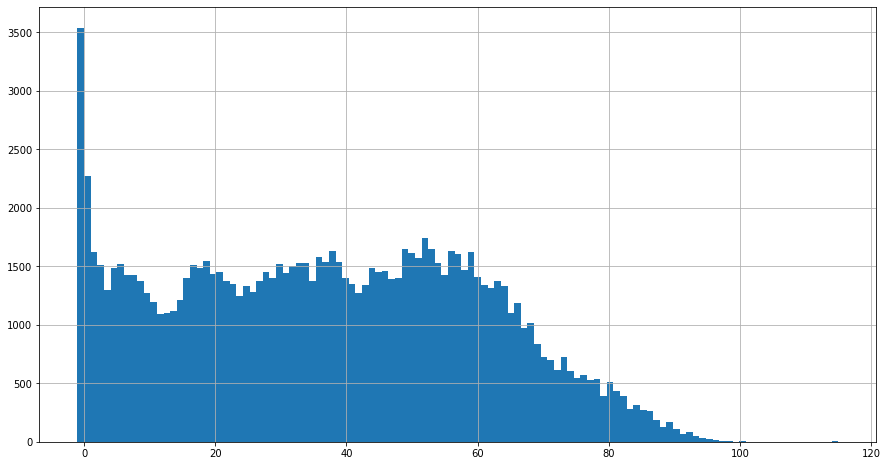

In [14]:
df.age.hist(figsize=(15, 8), bins = 115);

In [15]:
# discart the ages bellow zero
df = df.query('age >= 0')
print(sorted(df.age.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


In [16]:
df['handicap'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [17]:
df['handicap'].value_counts()

0    108285
1      2042
2       183
3        13
4         3
Name: handicap, dtype: int64

In [18]:
# # if we wont categorize handicap into binary - 0/1
# df.loc[df.handicap > 1, 'handicap'] = 1
# df.handicap.unique()

In [19]:
# creating the first column "appointment_week_day"
df['appointment_week_day'] = df.appointment_day.map(lambda day: day.day_name())
df.appointment_week_day.head(7000)

0        Friday
1        Friday
2        Friday
3        Friday
4        Friday
         ...   
6995     Friday
6996    Tuesday
6997    Tuesday
6998    Tuesday
6999    Tuesday
Name: appointment_week_day, Length: 7000, dtype: object

In [20]:
# solving problem "DatetimeArray subtraction must have the same timezones or no timezones"
#df['appointment_day'] = df['appointment_day'].dt.tz_convert(None)
df['scheduled_day'] = df['scheduled_day'].dt.tz_convert(None)

In [21]:
# creating the second column "appointment_waiting_time"
df["appointment_waiting_days"] = df.appointment_day - df.scheduled_day
df.appointment_waiting_days.head(10)

0   -1 days +05:21:52
1   -1 days +07:51:33
2   -1 days +07:40:56
3   -1 days +06:30:29
4   -1 days +07:52:37
5     1 days 15:23:09
6     1 days 08:54:48
7     1 days 08:20:02
8   -1 days +15:57:44
9     1 days 11:11:35
Name: appointment_waiting_days, dtype: timedelta64[ns]

In [22]:
# well it seams that some are treated on the same day that they scheduled
# we can prevent that weird value by calculating the the "absolute value" of this column
# and then converting the "time" to "days"
df.appointment_waiting_days = df.appointment_waiting_days.abs().dt.days
df.appointment_waiting_days.head(10)

0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    1
8    0
9    1
Name: appointment_waiting_days, dtype: int64

In [23]:
#  our data looks cleanning
df.head(5)

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handicap,received_sms,no_show,appointment_week_day,appointment_waiting_days
0,29872499824296,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,no,Friday,0
1,558997776694438,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,no,Friday,0
2,4262962299951,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,no,Friday,0
3,867951213174,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,no,Friday,0
4,8841186448183,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,no,Friday,0



## Wide loook on our data


In [24]:
# first let's re-see our dataset description
df.describe()

,age,scholarship,hipertension,diabetes,alcoholism,handicap,received_sms,appointment_waiting_days
count,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,9.532915
std,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,15.027724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,178.000000


In [25]:
df.info() # Waiiting days into int?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
patient_id                  110526 non-null object
gender                      110526 non-null object
scheduled_day               110526 non-null datetime64[ns]
appointment_day             110526 non-null datetime64[ns]
age                         110526 non-null int64
neighbourhood               110526 non-null object
scholarship                 110526 non-null int64
hipertension                110526 non-null int64
diabetes                    110526 non-null int64
alcoholism                  110526 non-null int64
handicap                    110526 non-null int64
received_sms                110526 non-null int64
no_show                     110526 non-null object
appointment_week_day        110526 non-null object
appointment_waiting_days    110526 non-null int64
dtypes: datetime64[ns](2), int64(8), object(5)
memory usage: 13.5+ MB


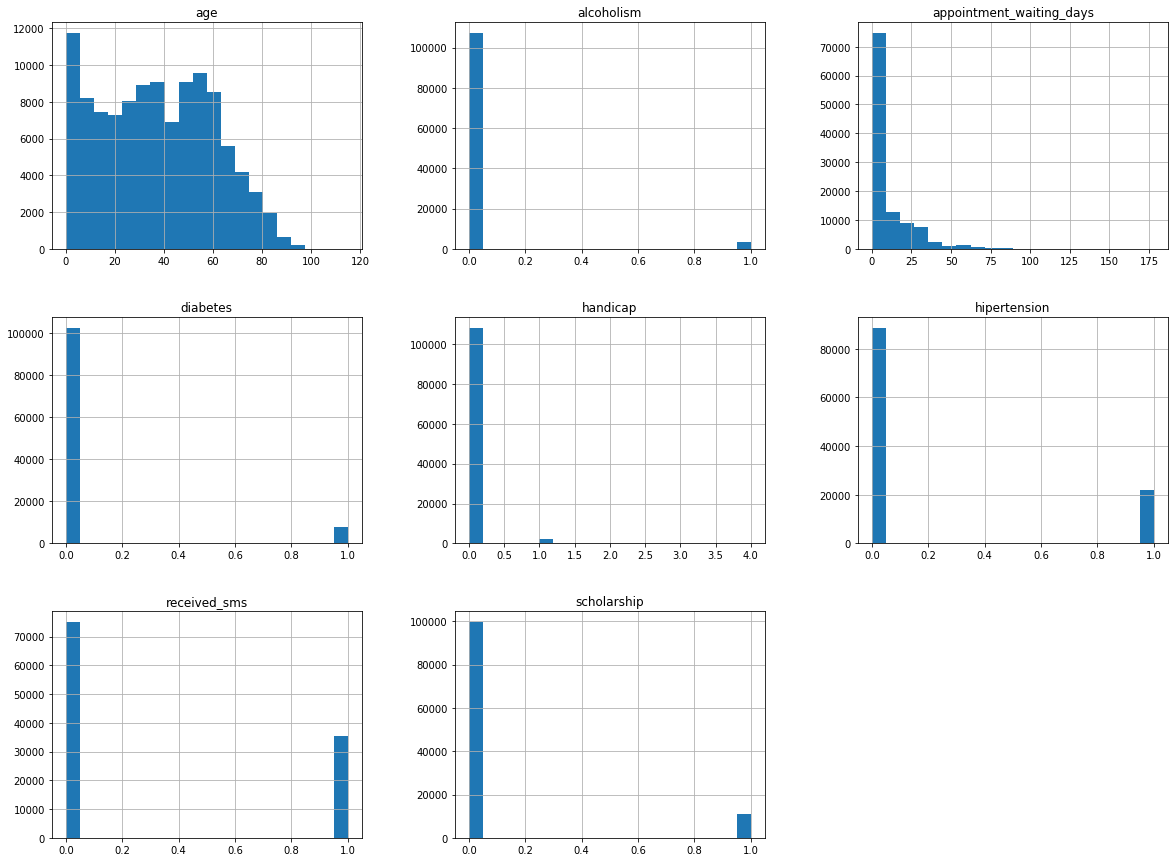

In [26]:
# and plot basic histogram charts
df.hist(figsize=(20, 15), bins = 20);

- most of the patients 
  - are bellow 60 years old
  - doesn't suffer from alcoholism/diabetes/hipertension
  - are not handicapped
  - doesn't received a reminder sms
  - aren't in the "Bolsa familia" program
  - doesn't missed the appointment



Well, we can't see too well our data, let's plot a better chart

## 3. Basic feature engineering

In [27]:
df.sample(10)

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handicap,received_sms,no_show,appointment_week_day,appointment_waiting_days
89587,3957599481989,F,2016-04-25 13:32:28,2016-06-01,0,BONFIM,0,0,0,0,0,0,yes,Wednesday,36
92942,7677448812919,M,2016-05-30 11:33:24,2016-06-08,26,SANTA LÚCIA,0,0,0,0,0,1,yes,Wednesday,8
103847,342954879,F,2016-06-08 06:57:09,2016-06-08,38,SANTO ANDRÉ,1,0,0,0,0,0,no,Wednesday,0
28947,98796838771249,M,2016-05-02 08:49:59,2016-05-12,35,ROMÃO,0,0,0,0,0,1,no,Thursday,9
76572,51271164184928,F,2016-05-13 14:52:07,2016-05-13,41,ANDORINHAS,1,1,0,0,0,0,no,Friday,0
49338,21212445622584,F,2016-04-25 17:19:46,2016-05-20,8,JARDIM DA PENHA,0,0,0,0,0,0,yes,Friday,24
63637,624921835131,M,2016-05-03 13:53:59,2016-05-04,3,NOVA PALESTINA,0,0,0,0,0,0,no,Wednesday,0
11635,92336159128874,M,2016-05-20 14:11:26,2016-05-25,38,MARUÍPE,0,0,0,0,0,1,no,Wednesday,4
65870,352216741419,F,2016-05-06 11:17:34,2016-05-06,10,SÃO CRISTÓVÃO,0,0,0,0,0,0,no,Friday,0
43408,692248461344,F,2016-04-26 17:56:37,2016-05-05,74,GOIABEIRAS,0,0,0,0,0,1,no,Thursday,8


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
patient_id                  110526 non-null object
gender                      110526 non-null object
scheduled_day               110526 non-null datetime64[ns]
appointment_day             110526 non-null datetime64[ns]
age                         110526 non-null int64
neighbourhood               110526 non-null object
scholarship                 110526 non-null int64
hipertension                110526 non-null int64
diabetes                    110526 non-null int64
alcoholism                  110526 non-null int64
handicap                    110526 non-null int64
received_sms                110526 non-null int64
no_show                     110526 non-null object
appointment_week_day        110526 non-null object
appointment_waiting_days    110526 non-null int64
dtypes: datetime64[ns](2), int64(8), object(5)
memory usage: 13.5+ MB


In [29]:
df.select_dtypes(include=[np.object]).columns

Index(['patient_id', 'gender', 'neighbourhood', 'no_show',
       'appointment_week_day'],
      dtype='object')

In [30]:
#ekstratction caterogical features form object columns 
cat_feats = df.select_dtypes(include=[np.object]).columns
for cat_feat in cat_feats:
    df['{0}_cat'.format(cat_feat)] = pd.factorize(df[cat_feat])[0]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 20 columns):
patient_id                  110526 non-null object
gender                      110526 non-null object
scheduled_day               110526 non-null datetime64[ns]
appointment_day             110526 non-null datetime64[ns]
age                         110526 non-null int64
neighbourhood               110526 non-null object
scholarship                 110526 non-null int64
hipertension                110526 non-null int64
diabetes                    110526 non-null int64
alcoholism                  110526 non-null int64
handicap                    110526 non-null int64
received_sms                110526 non-null int64
no_show                     110526 non-null object
appointment_week_day        110526 non-null object
appointment_waiting_days    110526 non-null int64
patient_id_cat              110526 non-null int64
gender_cat                  110526 non-null int64
neighbourhood_ca

In [32]:
### Geting all numeric feats and return X and y for basic predict

def get_feats(df, black_list=['no_show_cat', 'patient_id_cat']):
#def get_feats(df, black_list=['no_show_cat', 'patient_id_cat']):
    feats = df.select_dtypes(np.number).columns
    return [x for x in feats if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    X = df[feats].values
    y = df['no_show'].values
    
    return X, y

X, y = get_X_y(df)
feats = get_feats(df)
feats 

['age',
 'scholarship',
 'hipertension',
 'diabetes',
 'alcoholism',
 'handicap',
 'received_sms',
 'appointment_waiting_days',
 'gender_cat',
 'neighbourhood_cat',
 'appointment_week_day_cat']

## 4. Oversampling on predicting Show-Up/No-Show.

In [33]:
#pip install imbalanced-learn - only install library
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

#Laadind modeland validations metod
from numpy import mean
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold


#models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb 


import scikitplot as skplt #vizualization learning courve etc.

#from imblearn.pipeline import Pipeline


In [34]:
# Basic example of random oversampling 

from sklearn.datasets import make_classification
# define dataset
X_test, y_test = make_classification(n_samples=10000, weights=[0.99], flip_y=0)
# summarize class distribution
print('size of inbalaced dataset',Counter(y_test))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy='auto')
#oversample = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_test, y_test)
# summarize class distribution
print('size of oversmapled dataset',Counter(y_over))

size of inbalaced dataset Counter({0: 9900, 1: 100})
size of oversmapled dataset Counter({0: 9900, 1: 9900})


In [35]:
# sisze of ours inbalacnced datset  - target value 'no_show' column
df['no_show'].value_counts()

no     88207
yes    22319
Name: no_show, dtype: int64

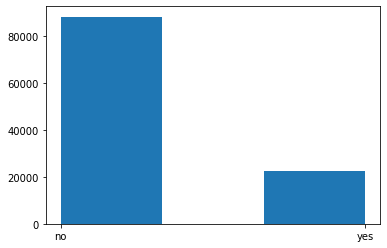

In [36]:
plt.hist(y, bins=3);

X shape (110526, 11)
y shape (110526,)
accuracy: 0.731
y_pred shape (110526,)


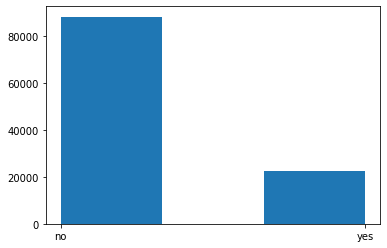

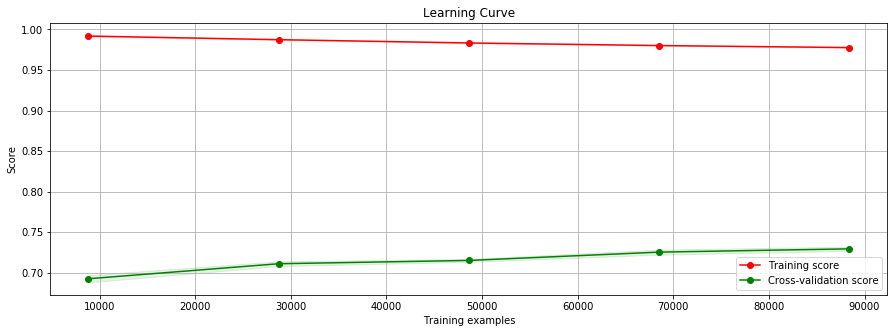

In [37]:
## Predict of sisze inbalacnced datset(No-Show). We use F1 score 
model =  DecisionTreeClassifier()


#plt.legend(loc='best')
plt.hist(y, bins=3)
#plt.plot(y, label="attended")
#plt.show();
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('y shape',y.shape)
#print('y shape',y.unique)

print('accuracy: %.3f' % score)


skplt.estimators.plot_learning_curve(model, X, y,figsize=(15,5), cv=cv,  scoring='accuracy');
y_pred = cross_val_predict(model,X,y, cv=cv)
print('y_pred shape',y_pred.shape)
# plt.hist(y_pred, bins=3); 
# plt.schow

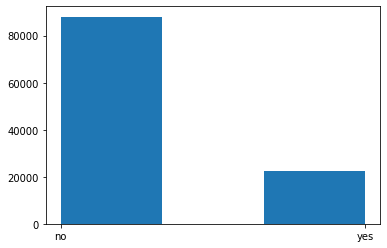

In [38]:
# Distrubytion of prediction value
y_pred = cross_val_predict(model,X,y, cv=cv)
plt.hist(y_pred, bins=3); 

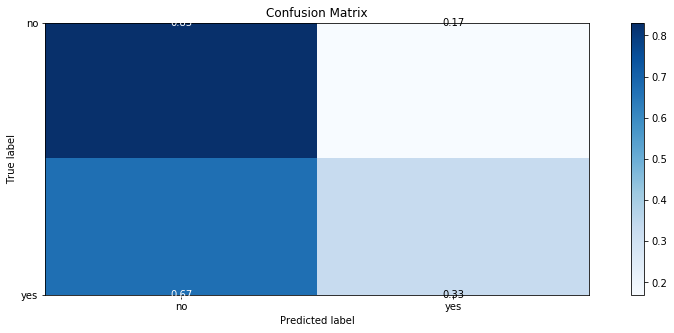

In [39]:
title='Confusion Matrix'
skplt.metrics.plot_confusion_matrix(y,y_pred,title=title, normalize=True, figsize=(15,5));

In [40]:
accuracy_score(y, y_pred)

0.7296111322222826

Distribution of target value  Counter({'no': 88207, 'yes': 88207})
X shape (110526, 11)
X_over shape (176414, 11)
y shape (110526,)
y_over shape (176414,)
accuracy: 0.870
y_pred shape (176414,)


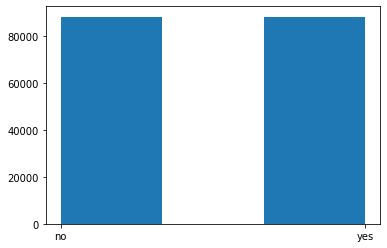

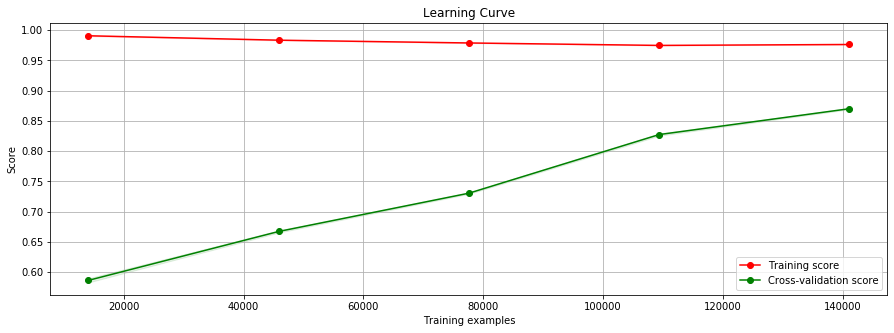

In [41]:
# define model
model =  DecisionTreeClassifier()
# print  fit and apply the transform
oversample = RandomOverSampler(sampling_strategy='auto')
X_over, y_over = oversample.fit_resample(X, y)

# summarize class distribution
print('Distribution of target value ',Counter(y_over))

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(model, X_over, y_over, scoring='accuracy', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('X_over shape',X_over.shape)
print('y shape',y.shape)
print('y_over shape',y_over.shape)

print('accuracy: %.3f' % score)
plt.hist(y_over, bins=3);
skplt.estimators.plot_learning_curve(model, X_over, y_over,figsize=(15,5), cv=cv,  scoring=None);

y_pred = cross_val_predict(model,X_over,y_over, cv=cv)
print('y_pred shape',y_pred.shape)

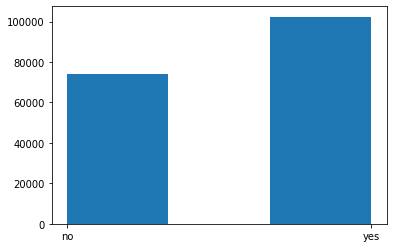

In [42]:
# Distribution of prediction value
y_pred = cross_val_predict(model,X_over,y_over, cv=cv)
plt.hist(y_pred, bins=3); 

In [43]:
y_pred.shape

(176414,)

In [44]:
y_over.shape

(176414,)

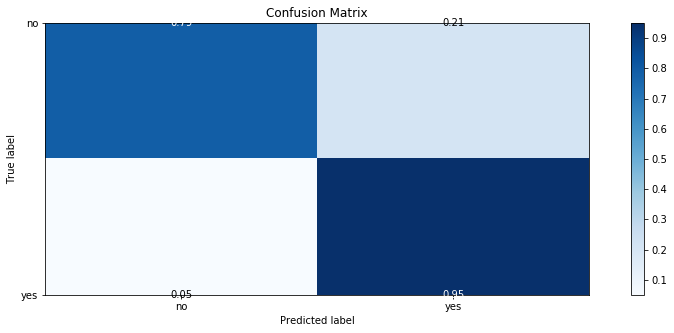

In [45]:
title='Confusion Matrix'
skplt.metrics.plot_confusion_matrix(y_over,y_pred,title=title, normalize=True, figsize=(15,5));

In [48]:
accuracy_score(y_over, y_pred)

0.8706791977960933

Counter({'no': 88207, 'yes': 88207})
X shape (110526, 11)
X_over shape (176414, 11)
y shape (110526,)
y_over shape (176414,)
accuracy: 0.678


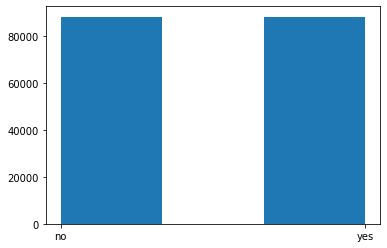

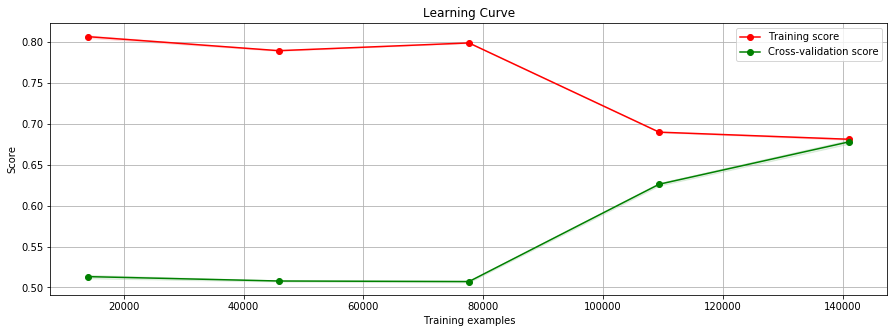

In [52]:
# define model
model =  xgb.XGBClassifier(random_state=0, n_estimators=40, max_depth = 4)
# print  fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(model, X_over, y_over, scoring='accuracy', cv=cv, n_jobs=-1)
score = mean(scores)


print('X shape',X.shape)
print('X_over shape',X_over.shape)
print('y shape',y.shape)
print('y_over shape',y_over.shape)


print('accuracy: %.3f' % score)
plt.hist(y_over, bins=3);
skplt.estimators.plot_learning_curve(model, X_over, y_over,figsize=(15,5), cv=cv,  scoring=None);

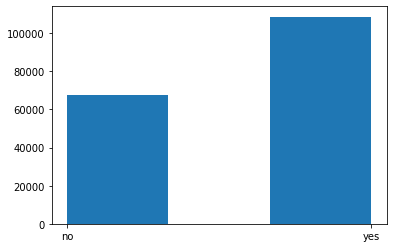

In [53]:
# Distribution of prediction value
y_pred = cross_val_predict(model,X_over,y_over, cv=cv)
plt.hist(y_pred, bins=3); 

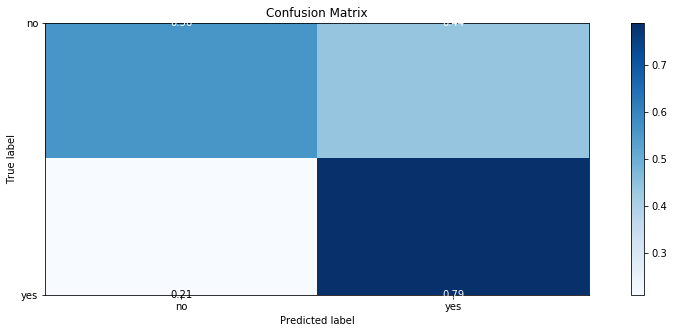

In [54]:
title='Confusion Matrix'
skplt.metrics.plot_confusion_matrix(y_over,y_pred,title=title, normalize=True, figsize=(15,5));

In [ ]:
def run_cv_model_normal_sampling(model_cls, model_params, X,y,feats,cv=3, scoring = 'accuracy', plot_learning_curve= True, plot_confusion_matrix = True, plot_feature_importances = True, plot_no_show_disb=True, plot_no_show_disb_pred = False):
    
    scores= cross_val_score(model_cls(**model_params),X,y, cv=cv, scoring=scoring)
    print('mean{}, std={}, scores{}'.format(np.round(np.mean(scores),2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_no_show_disb:
        plt.hist(y, bins=3);
    if plot_no_show_disb_pred:
        y_pred = cross_val_predict(model_cls(**model_params),X,y, cv=cv)
        plt.hist(y_pred, bins=3); 
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X,y)
        title ='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15,5), cv=cv, scoring=scoring);
         
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params),X,y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y,y_pred,title=title, normalize=True, figsize=(15,5));
        
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X,y)
        title ='Feature Importtance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names= feats,title=title, x_tick_rotation = 90, figsize =(14,5));


In [ ]:
def run_cv_model_oversampling(model_cls, model_params, X,y, feats,cv=3, scoring = 'accuracy', plot_learning_curve= True, plot_confusion_matrix = True, plot_feature_importances = True, plot_no_show_disb=True, plot_no_show_disb_pred = False, sampling_strategy= 'minority',):
    #oversample = RandomOverSampler(sampling_strategy='minority')
    #oversample = RandomOverSampler(sampling_strategy=0.5)
    oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
    X_over, y_over = oversample.fit_resample(X, y)
    
    
    scores= cross_val_score(model_cls(**model_params),X_over,y_over, cv=cv, scoring=scoring)
    print('mean{}, std={}, scores{}'.format(np.round(np.mean(scores),2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_no_show_disb:
        plt.hist(y_over, bins=3);
#     if plot_no_show_disb_pred:
#         y_pred = cross_val_predict(model_cls(**model_params),X_over,y_over, cv=cv)
#         plt.hist(y_pred, bins=3); 
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X_over,y_over)
        title ='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X_over, y_over, title=title,figsize=(15,5), cv=cv, scoring=scoring);
         
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params),X_over,y_over, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y_over,y_pred,title=title, normalize=True, figsize=(15,5));
        
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_over,y_over)
        title ='Feature Importtance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names= feats,title=title, x_tick_rotation = 90, figsize =(14,5));


mean0.71, std=0.0, scores[0.7105206  0.7107106  0.71662776]


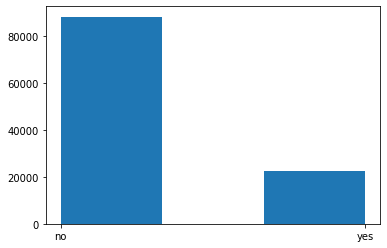

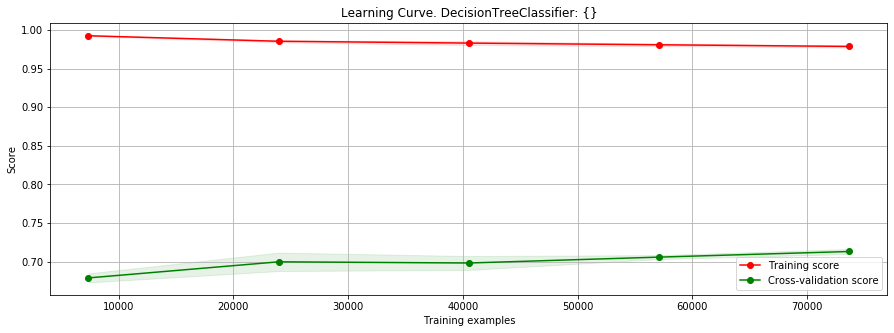

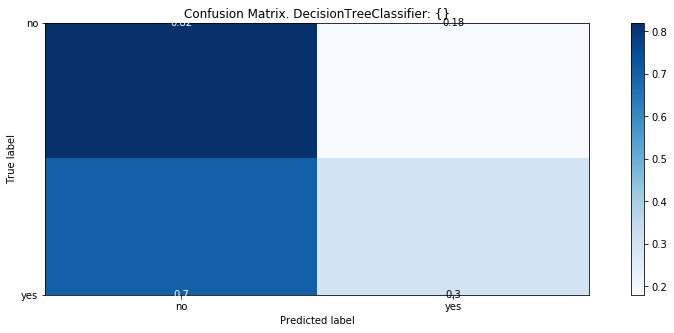

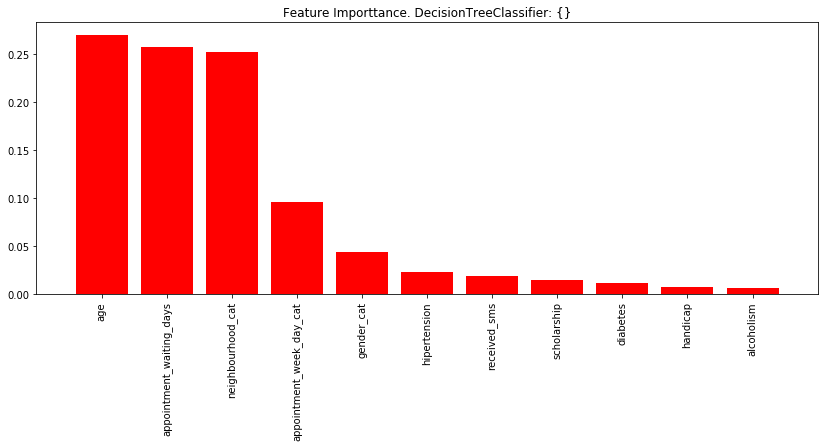

In [63]:
run_cv_model_normal_sampling(DecisionTreeClassifier, {}, X, y, feats,cv =3, scoring = 'accuracy')

mean0.83, std=0.01, scores[0.81722643 0.83197007 0.84409224]


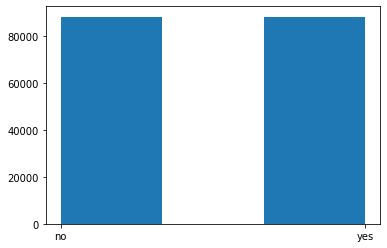

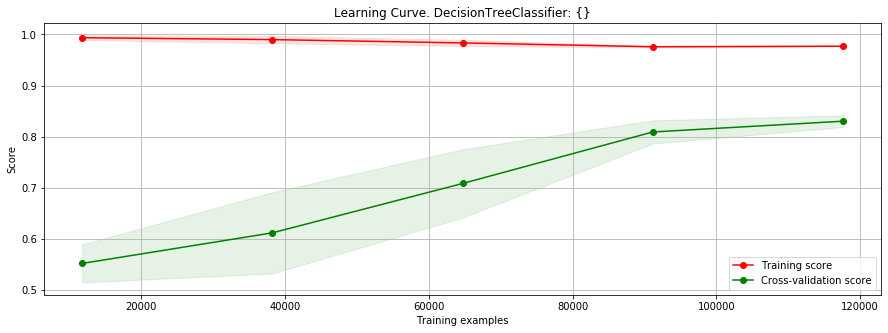

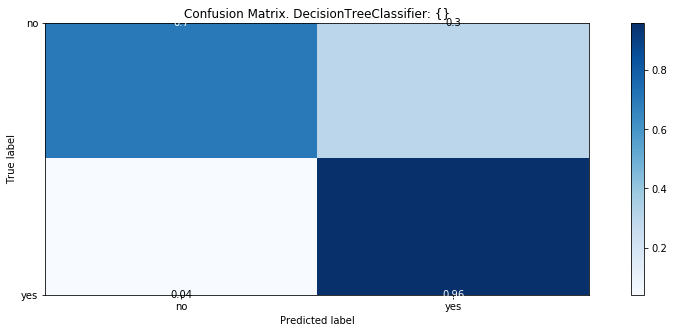

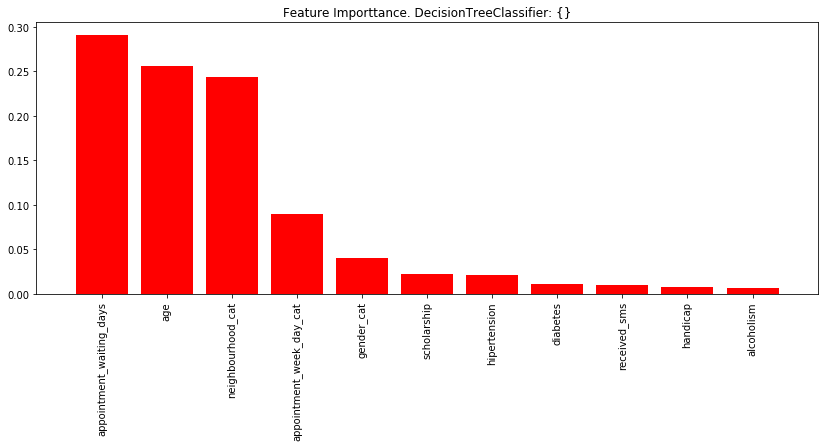

In [64]:
run_cv_model_oversampling(DecisionTreeClassifier, {}, X, y, feats)

mean0.8, std=0.0, scores[0.79808371 0.79805657 0.79805657]


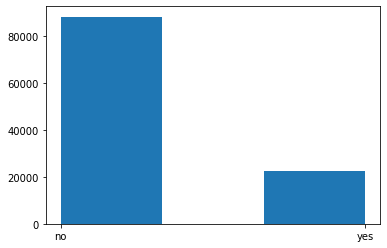

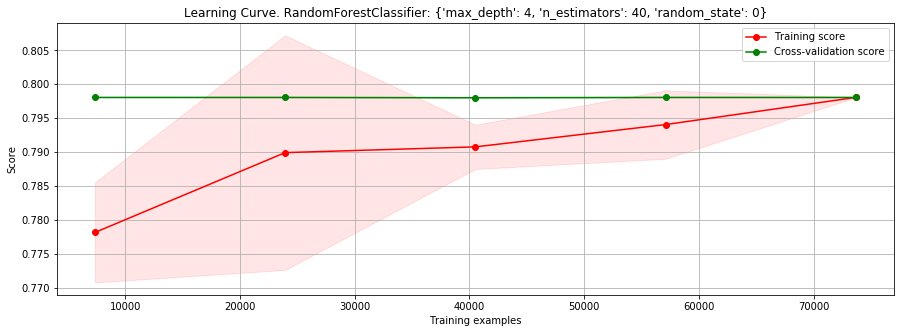

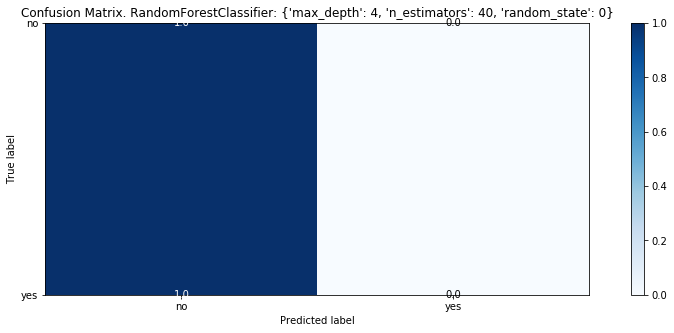

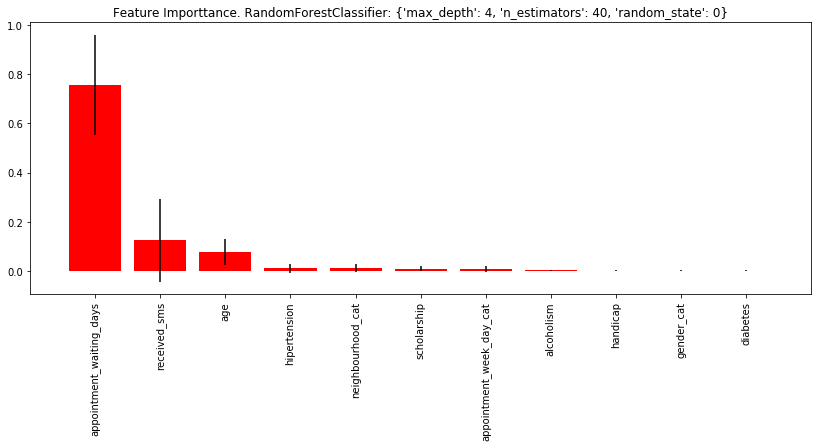

In [65]:
run_cv_model_normal_sampling(RandomForestClassifier, {'max_depth': 4, 'n_estimators': 40, 'random_state': 0}, X, y, feats)

In [ ]:
run_cv_model_oversampling(RandomForestClassifier, {'max_depth': 4, 'n_estimators': 40, accuracy_scoredom_state': 0}, X, y, feats)

mean0.66, std=0.01, scores[0.64807414 0.67393929 0.67071968]


## References

- Wikipedia - Sistema Único de Saúde (SUS). https://en.wikipedia.org/wiki/Sistema_%C3%9Anico_de_Sa%C3%BAde. Accessed in April, 2018.
- Kaggle Data Analyst Nanodegree project - first attempt- https://www.kaggle.com/kuroski/data-analyst-nanodegree-project-first-attempt/notebook
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


## Trash

In [ ]:
y_pred = cross_val_predict(RandomForestClassifier(max_depth =8, n_estimators = 80, max_features=11),X,y, cv=3)
skplt.metrics.plot_confusion_matrix(y,y_pred, normalize=True, figsize=(10,10));

In [ ]:
y_pred = cross_val_predict(RandomForestClassifier(max_depth =8, n_estimators = 80, max_features=11),X,y, cv=3)
skplt.metrics.plot_confusion_matrix(y,y_pred, normalize=True, figsize=(10,10));

In [ ]:
# define model
model =  xgb.XGBClassifier(random_state=0, n_estimators=100)
# print  fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_over, y_over, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)


print('X shape',X.shape)
print('X_over shape',X_over.shape)
print('y shape',y.shape)
print('y_over shape',y_over.shape)


print('F1 Score: %.3f' % score)
plt.hist(y_over, bins=3);
skplt.estimators.plot_learning_curve(model, X_over, y_over,figsize=(15,5), cv=cv,  scoring=None);

In [ ]:

y_pred = cross_val_predict(model_cls(**model_params),X,y, cv=cv)
title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y,y_pred,title=title, normalize=True, figsize=(15,5));


# example of evaluating a decision tree with random oversampling
# define pipeline
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# print  fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

In [ ]:
# example of evaluating a decision tree withot random oversampling
# define pipeline
steps = [ ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# print  fit and apply the transform
#X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

In [ ]:
# define model
model =  DecisionTreeClassifier()
# print  fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_over, y_over, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('X_over shape',X_over.shape)
print('F1 Score: %.3f' % score)
plt.hist(y_over, bins=3);
#skplt.estimators.plot_learning_curve(model, X_over, y_over,figsize=(15,5), cv=cv,  scoring=None);

In [ ]:
# example of evaluating a decision tree with random oversampling
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
import scikitplot as skplt

# define pipeline
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# print  fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('X_over shape',X_over.shape)
print('F1 Score: %.3f' % score)
plt.hist(y, bins=3);
#Learning Curve - it will take much time. it schould be  
skplt.estimators.plot_learning_curve(pipeline, X, y,figsize=(15,5), cv=cv,  scoring=None);

In [ ]:

# pipeline?!
pipeline = Pipeline([ 
    ('someName', someFunction(some args)),
    ('next Name', nextFuntion())
])

data = pipeline.fit_transform(dataframe)

## References

- Wikipedia - Sistema Único de Saúde (SUS). https://en.wikipedia.org/wiki/Sistema_%C3%9Anico_de_Sa%C3%BAde. Accessed in April, 2018.
- Kaggle Data Analyst Nanodegree project - first attempt- https://www.kaggle.com/kuroski/data-analyst-nanodegree-project-first-attempt/notebook
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


In [ ]:
## Predict of sisze of ours inbalacnced datset. We use F1 score 
model =  DecisionTreeClassifier()


#plt.legend(loc='best')
plt.hist(y, bins=3)
#plt.plot(y, label="attended")
#plt.show();
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(model, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('y shape',y.shape)
#print('y shape',y.unique)

print('F1 Score: %.3f' % score)


skplt.estimators.plot_learning_curve(model, X, y,figsize=(15,5), cv=cv,  scoring=None);
y_pred = cross_val_predict(model,X,y, cv=cv)
print('y_pred shape',y_pred.shape)
# plt.hist(y_pred, bins=3); 
# plt.schow

In [ ]:
## Predict of sisze of ours inbalacnced datset. We use F1 score 
model =  DecisionTreeClassifier()

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('y shape',y.shape)

print('F1 Score: %.3f' % score)
plt.plot(y, label="attended")
plt.legend(loc='best'); 
plt.hist(y, bins=3);
skplt.estimators.plot_learning_curve(model, X, y,figsize=(15,5), cv=cv,  scoring=None);

In [ ]:
## Predict of sisze of ours inbalacnced datset. We use F1 score 
model =  DecisionTreeClassifier()


#plt.legend(loc='best')
plt.hist(y, bins=3)
#plt.plot(y, label="attended")
#plt.show();
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(model, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)

print('X shape',X.shape)
print('y shape',y.shape)
#print('y shape',y.unique)

print('F1 Score: %.3f' % score)


skplt.estimators.plot_learning_curve(model, X, y,figsize=(15,5), cv=cv,  scoring='f1_micro');
y_pred = cross_val_predict(model,X,y, cv=cv)
print('y_pred shape',y_pred.shape)
# plt.hist(y_pred, bins=3); 
# plt.schow